In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

In [ ]:
train_path='/content/drive/MyDrive/Colab Notebooks/sep769 cyber physical system deep learning/project/Original Data/train'
test_path='/content/drive/MyDrive/Colab Notebooks/sep769 cyber physical system deep learning/project/Original Data/test'

model_save_path='/content/drive/MyDrive/Colab Notebooks/sep769 cyber physical system deep learning/project/models'

def save_model(path, model, model_name, history, train_time):
  import os
  os.makedirs(path, exist_ok=True)

  model_save_path = os.path.join(path, f"{model_name}.keras")
  model.save(model_save_path)

  hist = pd.DataFrame(history.history)
  hist["epochs"] = history.epoch
  hist_save_path = os.path.join(path, f"{model_name}_history.csv")
  hist.to_csv(hist_save_path)

  import csv
  train_time_save_path = os.path.join(path, 'train_time.csv')
  with open(train_time_save_path, 'a', newline='') as file:
        csv_writer = csv.writer(file)
        if not os.path.isfile(train_time_save_path):
          csv_writer.writerow(['model_name', 'train_time'])
        csv_writer.writerow([model_name, f"{train_time:.2f}"])

  print(f"{model_name} saved")

def load_model(path, model_name):
  import os
  from tensorflow.keras.models import load_model
  model = load_model(os.path.join(path, f"{model_name}.keras"))
  history = pd.read_csv(os.path.join(path, f"{model_name}_history.csv"))
  return model, history


# Model_0: baseline model


## Import data
- split 80% for training and 20% for validation
- shuffle the data

In [ ]:
img_size = (224, 224)
batch_size = 32

train = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=7693,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
classes = train.class_names

val = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=7693,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

print(f"train set has {len(classes)} classes: {classes}")

Found 7242 files belonging to 4 classes.
Using 5794 files for training.
Found 7242 files belonging to 4 classes.
Using 1448 files for validation.
train set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']


## Data example

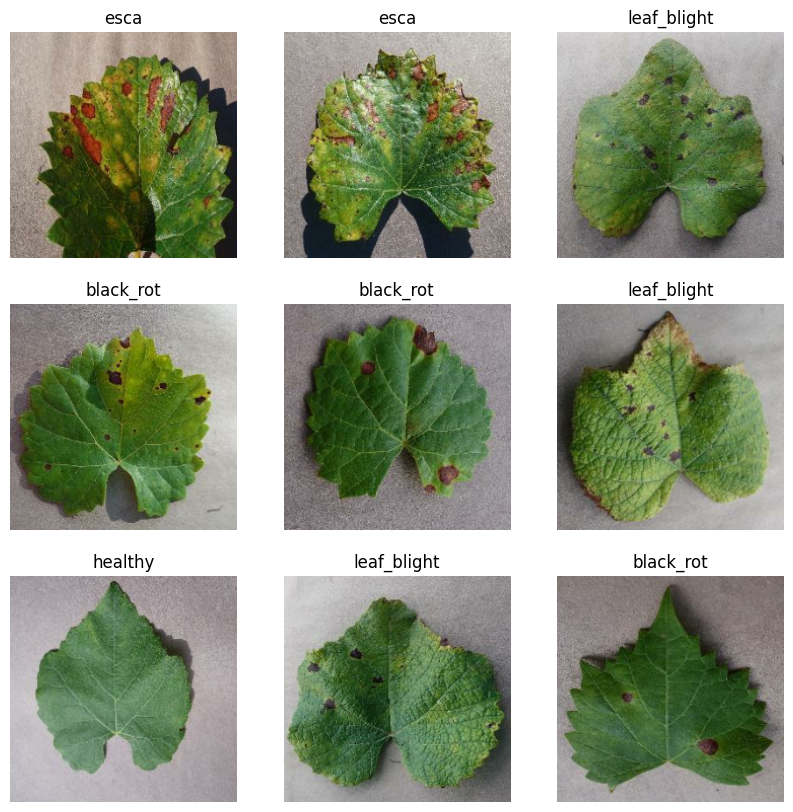

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.title(classes[labels[i]])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')

## Data preprocessing
- normalization
- shuffle data for each epoch
- configure the dataset for performance
 - keep the data in RAM after the first epoch
 - GPU and CPU coordination: overlaps data preprocessing and model training tasks


In [ ]:
normalization = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000)
train = train.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
train = train.prefetch(buffer_size=AUTOTUNE)

val = val.cache()
val = val.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)

## Model build

In [ ]:
def build_model():
  model = keras.Sequential([
      layers.Input(shape=(*img_size, 3)),
      layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(8, activation='relu'),
      keras.layers.Dense(len(classes), activation='softmax')])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

  return model

model_0 = build_model()
model_0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │         401,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,972 (1.55 MB)

 Trainable params: 406,972 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

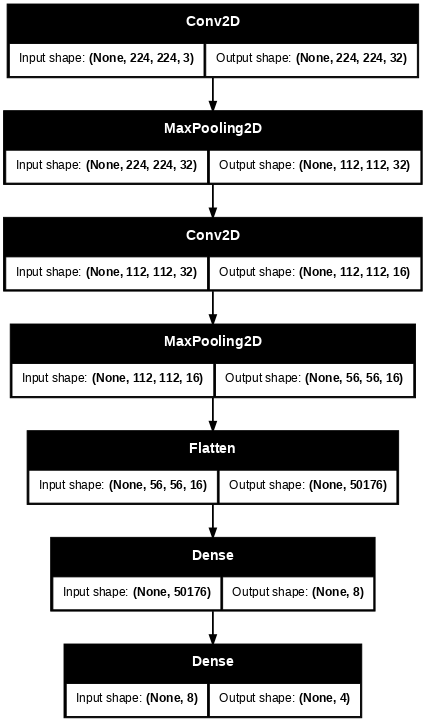

In [ ]:
tf.keras.utils.plot_model(model_0, show_shapes=True, expand_nested=True, dpi=64)

## Model training

In [ ]:
start = time.time()
history = model_0.fit(
        train,
        epochs=50,
        validation_data=val
)
stop = time.time()


Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 136s 575ms/step - accuracy: 0.3652 - loss: 1.3625 - val_accuracy: 0.6657 - val_loss: 0.7252
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7037 - loss: 0.6276 - val_accuracy: 0.7590 - val_loss: 0.5249
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7740 - loss: 0.5340 - val_accuracy: 0.8267 - val_loss: 0.4761
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8438 - loss: 0.3966 - val_accuracy: 0.8674 - val_loss: 0.3550
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8823 - loss: 0.3159 - val_accuracy: 0.8791 - val_loss: 0.3369
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9162 - loss: 0.2414 - val_accuracy: 0.8867 - val_loss: 0.2906
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9313 - loss: 0.1924 - val_accuracy: 0.9081 - val_loss: 0.2483
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9362 - loss: 0.1916 - val_a

In [ ]:
train_time = stop - start
print(f"Training time: {train_time:.2f} seconds")

Training time: 236.65 seconds


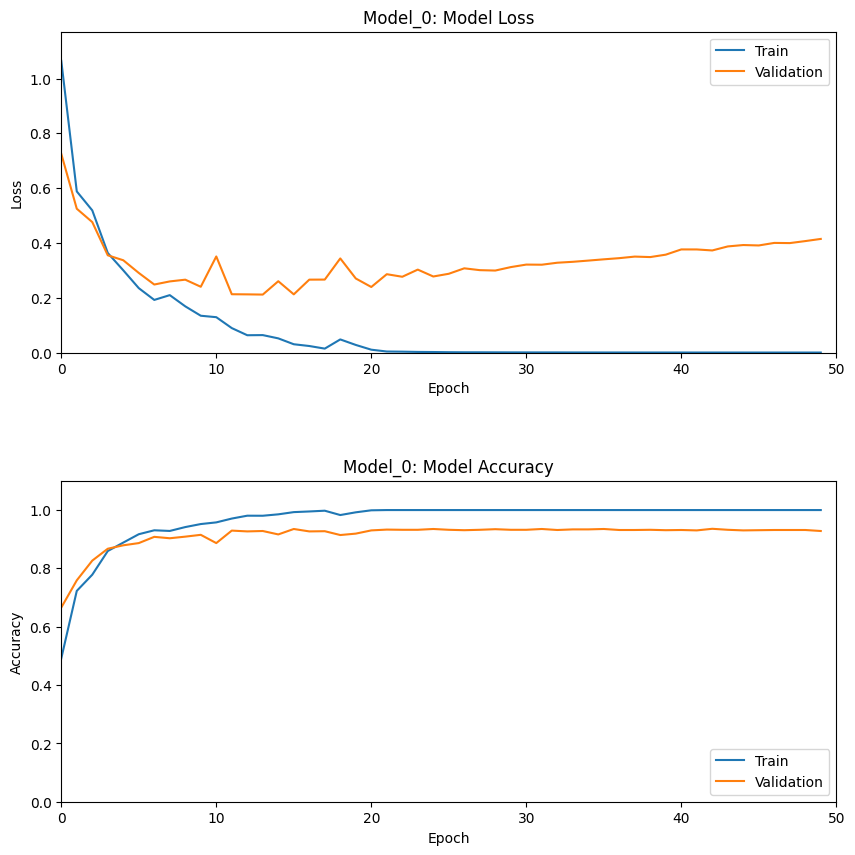

In [ ]:
hist = pd.DataFrame(history.history)
hist["epochs"] = history.epoch
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model_0: Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, len(hist["epochs"]))
plt.ylim(0, hist[["val_loss", "loss"]].values.max()*1.1)
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model_0: Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, len(hist["epochs"]))
plt.ylim(0, hist[["accuracy", "val_accuracy"]].values.max()*1.1)
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplots_adjust(hspace=0.4)

plt.show()

## Model evaluation

In [ ]:
test = keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)
classes = test.class_names
print(f"test set has {len(classes)} classes: {classes}")

normalization = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE
test = test.cache()
test = test.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

pred = model_0.predict(test)
pred_class = np.argmax(pred, axis=-1)

true_class = []
for images, labels in test:
  true_class.extend(labels.numpy())
true_class = np.array(true_class)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
accuracy = accuracy_score(true_class, pred_class)
precision = precision_score(true_class, pred_class, average='weighted')
recall = recall_score(true_class, pred_class, average='weighted')
f1 = f1_score(true_class, pred_class, average='weighted')
print(f'Accuracy Score: {accuracy:.2f} \nPrecision Score: {precision:.2f} \nF1 Score: {f1:.2f} \nRecall Score: {recall:.2f}')

from sklearn.metrics import classification_report
print('\nClassification Report:')
print(classification_report(true_class, pred_class, target_names=classes))

Found 1805 files belonging to 4 classes.
test set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step
Accuracy Score: 0.94 
Precision Score: 0.94 
F1 Score: 0.94 
Recall Score: 0.94

Classification Report:
              precision    recall  f1-score   support

   black_rot       0.90      0.93      0.92       472
        esca       0.95      0.91      0.93       480
     healthy       0.94      0.97      0.95       423
 leaf_blight       0.98      0.96      0.97       430

    accuracy                           0.94      1805
   macro avg       0.94      0.94      0.94      1805
weighted avg       0.94      0.94      0.94      1805



In [ ]:
save_model(model_save_path, model_0, 'model_0', history, train_time)

model_0 saved


# Model_1: fine turning the Model_0
- Additional conv block
- Dropout layer
- Image Augmentation
- EarlyStopping
- ReduceLROnPlateau

In [ ]:
img_size = (224, 224)
batch_size = 32

train = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=7693,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
classes = train.class_names
sample = train.take(1)

val = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=7693,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

print(f"train set has {len(classes)} classes: {classes}")

Found 7242 files belonging to 4 classes.
Using 5794 files for training.
Found 7242 files belonging to 4 classes.
Using 1448 files for validation.
train set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']


## Data preprocessing
- normalization
- image augmentation


In [ ]:
img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.5),
        layers.RandomFlip('horizontal'),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2)
    ]
)

normalization = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000)
train = train.map(lambda x, y: (img_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train = train.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
train = train.prefetch(buffer_size=AUTOTUNE)

val = val.cache()
val = val.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)

## Augmented image example

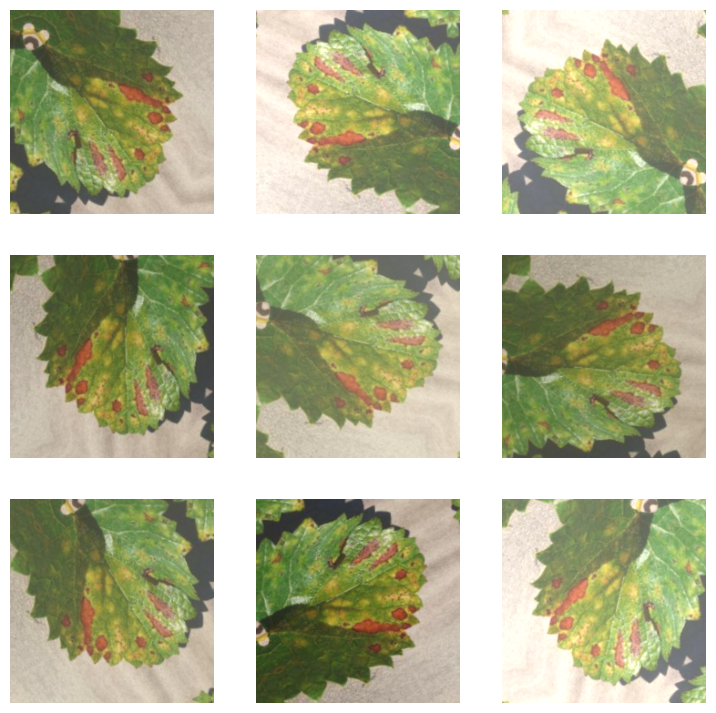

In [ ]:
plt.figure(figsize=(9, 9))
sample_augmented = sample.map(lambda x, y: (img_augmentation(x, training=True), y))
for images, _ in sample_augmented:
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_img = img_augmentation(images)
    plt.imshow(augmented_img[0].numpy().astype('uint8'))
    plt.axis('off')

## Model build


In [ ]:
def build_model():
  model = keras.Sequential([
      layers.Input(shape=(*img_size, 3)),

      layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(3,3)),
      layers.Dropout(0.2),

      layers.Conv2D(16, kernel_size=(5,5), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(3,3)),
      layers.Dropout(0.2),

      layers.Conv2D(8, kernel_size=(5,5), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(3,3)),
      layers.Dropout(0.2),

      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(len(classes), activation='softmax')])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

  return model

model_1 = build_model()
model_1.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 74, 74, 16)          │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 24, 24, 8)           │           3,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,244 (145.48 KB)

 Trainable params: 37,244 (145.48 KB)

 Non-trainable params: 0 (0.00 B)

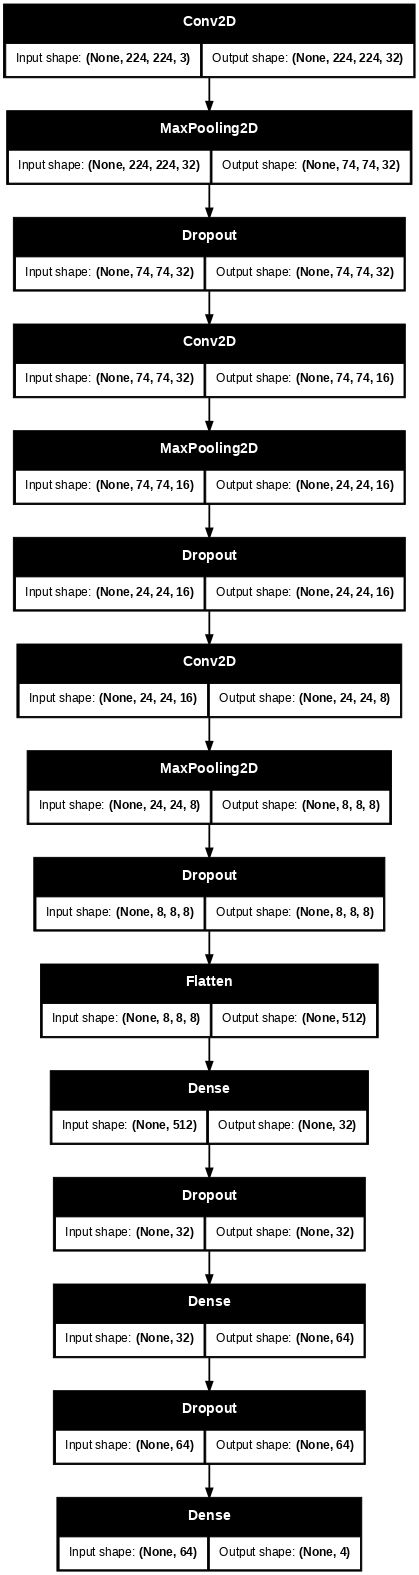

In [ ]:
tf.keras.utils.plot_model(model_1, show_shapes=True, expand_nested=True, dpi=64)

## Model training


In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

start = time.time()
history = model_1.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stop, reduce_lr]
)
stop = time.time()

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.2614 - loss: 1.3860 - val_accuracy: 0.4095 - val_loss: 1.1232 - learning_rate: 0.0010
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.4434 - loss: 1.1287 - val_accuracy: 0.5124 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5257 - loss: 1.0407 - val_accuracy: 0.4800 - val_loss: 0.9891 - learning_rate: 0.0010
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6301 - loss: 0.8719 - val_accuracy: 0.7141 - val_loss: 0.6462 - learning_rate: 0.0010
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7088 - loss: 0.7117 - val_accuracy: 0.7369 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7402 - loss: 0.6336 - val_accuracy: 0.8059 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7854 - loss: 0

In [ ]:
train_time = stop - start
print(f"Training time: {train_time:.2f} seconds")

Training time: 227.75 seconds


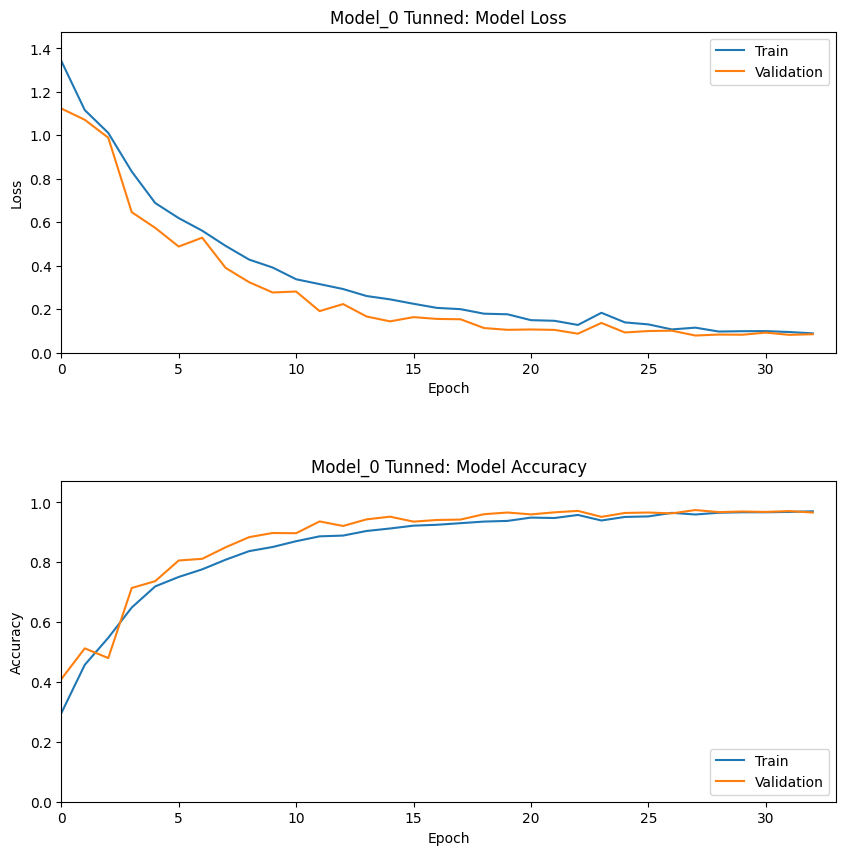

In [ ]:
hist = pd.DataFrame(history.history)
hist["epochs"] = history.epoch
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model_0 Tunned: Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, len(hist["epochs"]))
plt.ylim(0, hist[["val_loss", "loss"]].values.max()*1.1)
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model_0 Tunned: Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, len(hist["epochs"]))
plt.ylim(0, hist[["accuracy", "val_accuracy"]].values.max()*1.1)
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplots_adjust(hspace=0.4)

plt.show()

## Model evaluation


In [ ]:
test = keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)
classes = test.class_names
print(f"test set has {len(classes)} classes: {classes}")

normalization = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE
test = test.cache()
test = test.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

pred = model_1.predict(test)
pred_class = np.argmax(pred, axis=-1)

true_class = []
for images, labels in test:
  true_class.extend(labels.numpy())
true_class = np.array(true_class)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
accuracy = accuracy_score(true_class, pred_class)
precision = precision_score(true_class, pred_class, average='weighted')
recall = recall_score(true_class, pred_class, average='weighted')
f1 = f1_score(true_class, pred_class, average='weighted')
print(f'Accuracy Score: {accuracy:.2f} \nPrecision Score: {precision:.2f} \nF1 Score: {f1:.2f} \nRecall Score: {recall:.2f}')

from sklearn.metrics import classification_report
print('\nClassification Report:')
print(classification_report(true_class, pred_class, target_names=classes))

Found 1805 files belonging to 4 classes.
test set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
Accuracy Score: 0.97 
Precision Score: 0.97 
F1 Score: 0.97 
Recall Score: 0.97

Classification Report:
              precision    recall  f1-score   support

   black_rot       0.98      0.93      0.95       472
        esca       0.97      0.98      0.98       480
     healthy       1.00      1.00      1.00       423
 leaf_blight       0.94      1.00      0.97       430

    accuracy                           0.97      1805
   macro avg       0.97      0.97      0.97      1805
weighted avg       0.97      0.97      0.97      1805



In [ ]:
save_model(model_save_path, model_1, 'model_1', history, train_time)

model_1 saved


# Transfer Learning


In [ ]:
def load_train_data(path, img_size=(224, 224), train_val_split=0.2, batch_size=32):
  train = keras.utils.image_dataset_from_directory(
      path,
      validation_split=train_val_split,
      subset="training",
      seed=7693,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=True
  )
  classes = train.class_names

  val = keras.utils.image_dataset_from_directory(
      path,
      validation_split=train_val_split,
      subset="validation",
      seed=7693,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=True
  )

  print(f"train set has {len(classes)} classes: {classes}")

  return train, val, classes

def load_test_data(path, img_size=(224, 224), batch_size=32):
  test = keras.utils.image_dataset_from_directory(
      path,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=False
  )
  classes = test.class_names

  print(f"test set has {len(classes)} classes: {classes}")

  return test, classes

def train_data_preprocessing(train, val, preprocess_input):
  img_augmentation = keras.Sequential([
      layers.RandomRotation(0.5),
      layers.RandomFlip('horizontal'),
      layers.RandomContrast(0.3),
      layers.RandomBrightness(0.3)
  ])

  AUTOTUNE = tf.data.AUTOTUNE
  train = train.cache().shuffle(1000)
  train = train.map(lambda x, y: (img_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  train = train.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
  train = train.prefetch(buffer_size=AUTOTUNE)

  val = val.cache()
  val = val.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
  val = val.prefetch(buffer_size=AUTOTUNE)

  return train, val

def test_data_preprocessing(test, preprocess_input):
  AUTOTUNE = tf.data.AUTOTUNE
  test = test.cache()
  test = test.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
  test = test.prefetch(buffer_size=AUTOTUNE)
  return test

def plot_history(history, model_name):
  hist = pd.DataFrame(history.history)
  hist["epochs"] = history.epoch
  plt.figure(figsize=(10, 10))

  plt.subplot(2, 1, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f"Transfer Learning {model_name}: Model Loss")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xlim(0, len(hist["epochs"]))
  plt.ylim(0, hist[["val_loss", "loss"]].values.max()*1.1)
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(2, 1, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f"Transfer Learning {model_name}: Model Accuracy")
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xlim(0, len(hist["epochs"]))
  plt.ylim(0, hist[["accuracy", "val_accuracy"]].values.max()*1.1)
  plt.legend(['Train', 'Validation'], loc='lower right')

  plt.subplots_adjust(hspace=0.4)

  plt.show()

def model_evaluation(model, test):
  pred = model.predict(test)
  pred_class = np.argmax(pred, axis=-1)

  true_class = []
  for images, labels in test:
    true_class.extend(labels.numpy())
  true_class = np.array(true_class)

  from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
  accuracy = accuracy_score(true_class, pred_class)
  precision = precision_score(true_class, pred_class, average='weighted')
  recall = recall_score(true_class, pred_class, average='weighted')
  f1 = f1_score(true_class, pred_class, average='weighted')
  print(f'Accuracy Score: {accuracy:.2f} \nPrecision Score: {precision:.2f} \nF1 Score: {f1:.2f} \nRecall Score: {recall:.2f}')

  from sklearn.metrics import classification_report
  print('\nClassification Report:')
  print(classification_report(true_class, pred_class, target_names=classes))

## Transfer Learning: ResNet50V2

### Model build

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

img_size = (224, 224)

train, val, classes = load_train_data(path=train_path, img_size=img_size, train_val_split=0.2, batch_size=32)
train, val = train_data_preprocessing(train, val, preprocess_input)

def build_model(input_shape, num_classes):
  base_model = ResNet50V2(input_shape=input_shape,
                         include_top=False,
                         weights='imagenet')
  base_model.trainable = False

  model = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

  return model

model_tl_resnet50v2 = build_model(input_shape=(*img_size, 3), num_classes=len(classes))
model_tl_resnet50v2.summary()

Found 7242 files belonging to 4 classes.
Using 5794 files for training.
Found 7242 files belonging to 4 classes.
Using 1448 files for validation.
train set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,630,500 (90.14 MB)

 Trainable params: 65,700 (256.64 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Model training

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
start = time.time()
history = model_tl_resnet50v2.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stop, reduce_lr]
)
stop = time.time()

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.7049 - loss: 0.7455 - val_accuracy: 0.9420 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9089 - loss: 0.2399 - val_accuracy: 0.9510 - val_loss: 0.1277 - learning_rate: 0.0010
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9160 - loss: 0.2058 - val_accuracy: 0.9641 - val_loss: 0.0893 - learning_rate: 0.0010
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9311 - loss: 0.1758 - val_accuracy: 0.9662 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9379 - loss: 0.1558 - val_accuracy: 0.9599 - val_loss: 0.1003 - learning_rate: 0.0010
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9401 - loss: 0.1617 - val_accuracy: 0.9682 - val_loss: 0.0866 - learning_rate: 0.0010
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9418 - loss: 0

In [ ]:
train_time = stop - start
print(f"Training time: {train_time:.2f} seconds")

Training time: 378.35 seconds


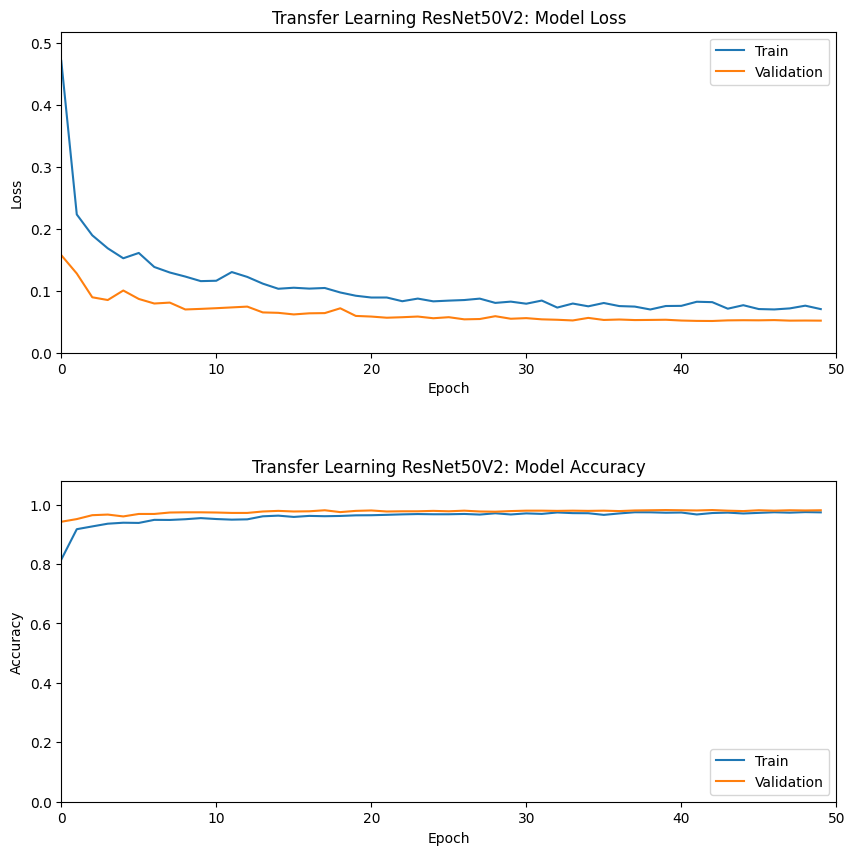

In [ ]:
plot_history(history, 'ResNet50V2')

### Model evaluation

In [ ]:
test, classes = load_test_data(test_path, img_size=(224, 224), batch_size=32)
test = test_data_preprocessing(test, preprocess_input)
model_evaluation(model_tl_resnet50v2, test)

Found 1805 files belonging to 4 classes.
test set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']
57/57 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step
Accuracy Score: 0.98 
Precision Score: 0.98 
F1 Score: 0.98 
Recall Score: 0.98

Classification Report:
              precision    recall  f1-score   support

   black_rot       0.97      0.97      0.97       472
        esca       0.97      0.97      0.97       480
     healthy       1.00      1.00      1.00       423
 leaf_blight       1.00      1.00      1.00       430

    accuracy                           0.98      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.98      0.98      0.98      1805



In [ ]:
save_model(model_save_path, model_tl_resnet50v2, 'model_tl_resnet50v2', history, train_time)

model_tl_resnet50v2 saved


## Transfer Learning: EfficientNetV2B0

### Model build

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

img_size = (300, 300)

train, val, classes = load_train_data(path=train_path, img_size=img_size, train_val_split=0.2, batch_size=32)
train, val = train_data_preprocessing(train, val, preprocess_input)

def build_model(input_shape, num_classes):
  base_model = EfficientNetV2B0(input_shape=input_shape,
                         include_top=False,
                         weights='imagenet')
  base_model.trainable = False

  model = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

  return model

model_tl_efficientnetv3b0 = build_model(input_shape=(*img_size, 3), num_classes=len(classes))
model_tl_efficientnetv3b0.summary()

Found 7242 files belonging to 4 classes.
Using 5794 files for training.
Found 7242 files belonging to 4 classes.
Using 1448 files for validation.
train set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 10, 10, 1280)        │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          40,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,960,436 (22.74 MB)

 Trainable params: 41,124 (160.64 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Model training

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
start = time.time()
history = model_tl_efficientnetv3b0.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stop, reduce_lr]
)
stop = time.time()

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 87s 230ms/step - accuracy: 0.7009 - loss: 0.7464 - val_accuracy: 0.9655 - val_loss: 0.1277 - learning_rate: 0.0010
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9249 - loss: 0.2329 - val_accuracy: 0.9779 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9437 - loss: 0.1709 - val_accuracy: 0.9820 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9561 - loss: 0.1305 - val_accuracy: 0.9820 - val_loss: 0.0565 - learning_rate: 0.0010
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9611 - loss: 0.1135 - val_accuracy: 0.9848 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9692 - loss: 0.1052 - val_accuracy: 0.9903 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9611 - 

In [ ]:
train_time = stop - start
print(f"Training time: {train_time:.2f} seconds")

Training time: 379.52 seconds


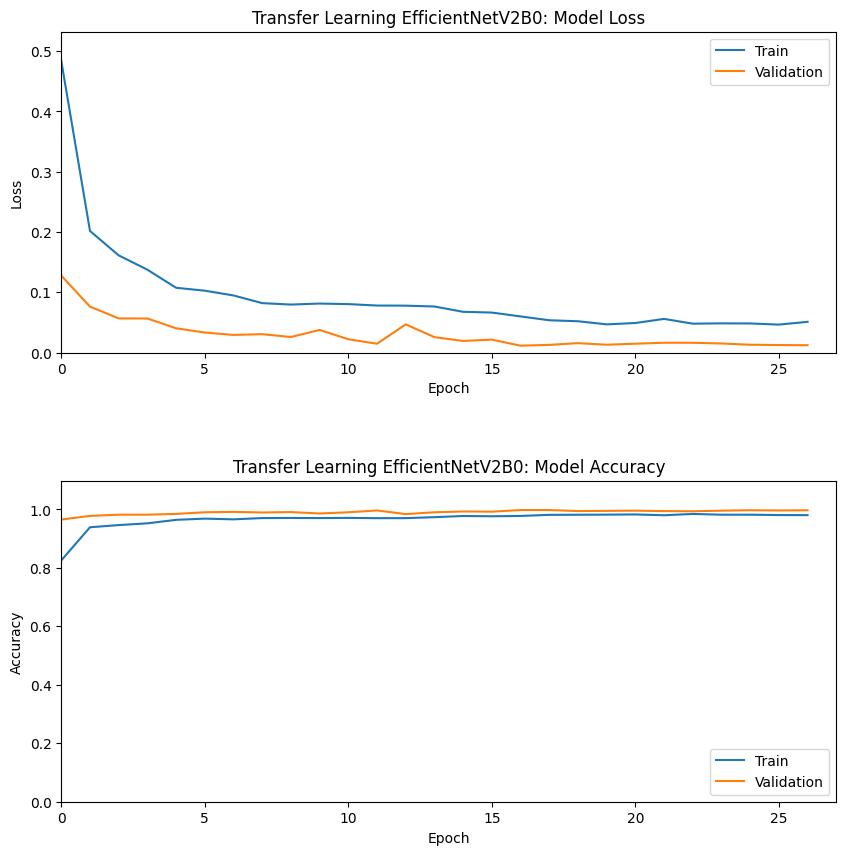

In [ ]:
plot_history(history, 'EfficientNetV2B0')

### Model evaluation

In [ ]:
test, classes = load_test_data(test_path, img_size=(300, 300), batch_size=32)
test = test_data_preprocessing(test, preprocess_input)
model_evaluation(model_tl_efficientnetv3b0, test)

Found 1805 files belonging to 4 classes.
test set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step
Accuracy Score: 0.99 
Precision Score: 0.99 
F1 Score: 0.99 
Recall Score: 0.99

Classification Report:
              precision    recall  f1-score   support

   black_rot       0.98      1.00      0.99       472
        esca       1.00      0.98      0.99       480
     healthy       1.00      1.00      1.00       423
 leaf_blight       1.00      1.00      1.00       430

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



In [ ]:
save_model(model_save_path, model_tl_efficientnetv3b0, 'model_tl_efficientnetv3b0', history, train_time)

model_tl_efficientnetv3b0 saved


## Transfer Learning: fine tune ResNet50V2



### Model build

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

img_size = (224, 224)

train, val, classes = load_train_data(path=train_path, img_size=img_size, train_val_split=0.2, batch_size=32)
train, val = train_data_preprocessing(train, val, preprocess_input)

base_model = ResNet50V2(input_shape=(*img_size, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
num_layer = len(base_model.layers)
print(f"number of layers in ResNet50V2: {num_layer}")


Found 7242 files belonging to 4 classes.
Using 5794 files for training.
Found 7242 files belonging to 4 classes.
Using 1448 files for validation.
train set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']
number of layers in ResNet50V2: 190


In [ ]:
num_layer_fine_tune = 5
for layer in base_model.layers[:-num_layer_fine_tune]:
  layer.trainable = False

def build_model(input_shape, num_classes):
  model = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

  return model

model_tl_resnet50v2finetune = build_model(input_shape=(*img_size, 3), num_classes=len(classes))
model_tl_resnet50v2finetune.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,630,500 (90.14 MB)

 Trainable params: 1,120,420 (4.27 MB)

 Non-trainable params: 22,510,080 (85.87 MB)

### Model training

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
start = time.time()
history = model_tl_resnet50v2finetune.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stop, reduce_lr]
)
stop = time.time()

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - accuracy: 0.8232 - loss: 0.4701 - val_accuracy: 0.9157 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9268 - loss: 0.1997 - val_accuracy: 0.9392 - val_loss: 0.1437 - learning_rate: 0.0010
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9476 - loss: 0.1520 - val_accuracy: 0.9682 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9604 - loss: 0.1278 - val_accuracy: 0.9468 - val_loss: 0.1471 - learning_rate: 0.0010
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9593 - loss: 0.1245 - val_accuracy: 0.9627 - val_loss: 0.0954 - learning_rate: 0.0010
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9584 - loss: 0.1199 - val_accuracy: 0.9199 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9654 - loss: 0

In [ ]:
train_time = stop - start
print(f"Training time: {train_time:.2f} seconds")

Training time: 383.18 seconds


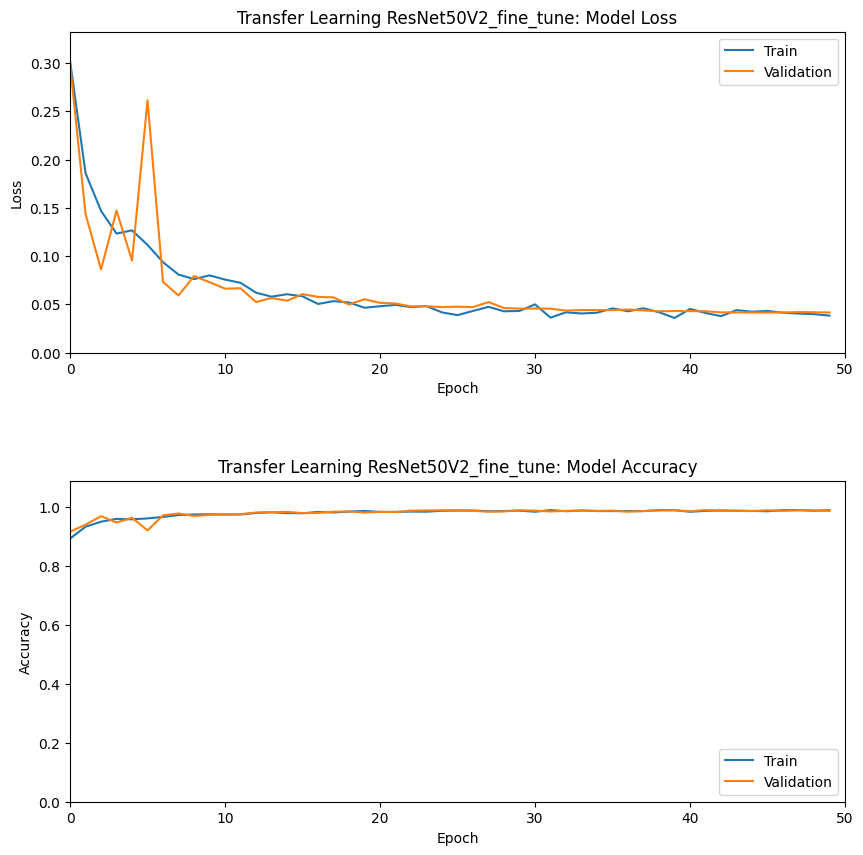

In [ ]:
plot_history(history, 'ResNet50V2_fine_tune')

### Model evaluation

In [ ]:
test, classes = load_test_data(test_path, img_size=(224, 224), batch_size=32)
test = test_data_preprocessing(test, preprocess_input)
model_evaluation(model_tl_resnet50v2finetune, test)

Found 1805 files belonging to 4 classes.
test set has 4 classes: ['black_rot', 'esca', 'healthy', 'leaf_blight']
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step
Accuracy Score: 0.99 
Precision Score: 0.99 
F1 Score: 0.99 
Recall Score: 0.99

Classification Report:
              precision    recall  f1-score   support

   black_rot       0.99      0.98      0.99       472
        esca       0.98      0.99      0.99       480
     healthy       1.00      1.00      1.00       423
 leaf_blight       1.00      1.00      1.00       430

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



In [ ]:
save_model(model_save_path, model_tl_resnet50v2finetune, 'model_tl_resnet50v2finetune', history, train_time)

model_tl_resnet50v2finetune saved
